# Preprocessing the data

In [9]:
# Das Notebook basiert auf diesem Turoial:
# https://www.analyticsvidhya.com/blog/2019/09/step-by-step-deep-learning-tutorial-video-classification-python/

In [22]:
# imports
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
#from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
from sklearn.metrics import classification_report

In [8]:
# preprocessing training labels
labels_df = pd.read_csv('material/labels.csv', sep=';')

# deleting videos with changing perspectives
labels_df = labels_df.drop(labels_df.loc[labels_df['Wechsel'] == True].index)
labels_df = labels_df.reset_index()

# droping unused columns:
labels_df.drop(columns=['index','Wechsel','ID'], inplace=True)
labels_df.rename(columns={'Camera Position (Side/Front/Upwards/Downwards)':'labels'}, inplace=True)

In [10]:
# storing the frames from training videos
for i in tqdm(range(labels_df.shape[0])):
    count = 0
    videoFile = labels_df['NameOfFile'][i]
    cap = cv2.VideoCapture('material/raw_training_videos/'+videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    #print(frameRate)
    x=1
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        #print(frameId)
        ret, frame = cap.read()
        if (ret != True):
            break
        #if (frameId % math.floor(frameRate) == 0):
            # storing the frames in a new folder named train_frames
        else:
            filename ='material/train_frames/' + videoFile +"_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()

100%|██████████| 101/101 [00:43<00:00,  2.32it/s]


In [21]:
# getting the names of all the images
images = glob("material/train_frames/*.jpg")
train_image = []
train_class = []
for i in tqdm(range(len(images))):
    # creating the image name
    name = images[i].split('/')[2].split('_f')[0]
    #print(name)
    train_image.append(images[i].split('/')[2])
    # creating the class of image
    train_class.append(labels_df['labels'].loc[labels_df['NameOfFile'] == name].values[0])
    
# storing the images and their class in a dataframe
train_data = pd.DataFrame()
train_data['image'] = train_image
train_data['class'] = train_class

# converting the dataframe into csv file 
train_data.to_csv('material/train_frames.csv',header=True, index=False)

100%|██████████| 8300/8300 [00:01<00:00, 5651.36it/s]


# Training the model starts here

In [1]:
#imports
import keras
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
# read in csv with labels for frames
train = pd.read_csv('material/train_frames.csv')

In [3]:
# reading in all the frames and saving them to a numpy array

# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the image size (480, 640, 3)
    '''
    TO DO:
    finde heraus was die ideale input größe der bilder ist. 
    '''
    img = image.load_img('material/train_frames/'+train['image'][i], target_size=(480, 640, 3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    '''
    TO DO:
    finde heraus was die optimale normalisierung der Bild daten ist
    '''
    img = img/480
    # appending the image to the train_image list
    train_image.append(img)
    
# converting the list to numpy array
X = np.array(train_image)

# shape of the array
X.shape

100%|██████████| 8300/8300 [02:35<00:00, 53.52it/s]


(8300, 480, 640, 3)

In [4]:
# creating train and test set

# separating the target
y = train['class']

# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

In [5]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

### Defining the architecture of the model

In [6]:
# creating the base model of pre-trained VGG16 model
'''
TO DO: 
finde heraus wie ein Model performt, welches von "scratch" creiert wird
'''
base_model = VGG16(weights='imagenet', include_top=False)

In [7]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [8]:
%%time
# extracting features for training frames

X_train = base_model.predict(X_train)
X_train.shape

CPU times: user 1min 9s, sys: 1min 11s, total: 2min 20s
Wall time: 1min 57s


(6640, 15, 20, 512)

In [9]:
%%time
# extracting features for validation frames

X_test = base_model.predict(X_test)
X_test.shape

CPU times: user 21.4 s, sys: 10.1 s, total: 31.6 s
Wall time: 24.8 s


(1660, 15, 20, 512)

In [10]:
# reshaping the training as well as validation frames in single dimension

X_train = X_train.reshape(6640, 15*20*512)
X_test = X_test.reshape(1660, 15*20*512)

In [11]:
%%time
# normalizing the pixel values

max = X_train.max()
X_train = X_train/max
X_test = X_test/max

CPU times: user 1 s, sys: 534 ms, total: 1.54 s
Wall time: 1.55 s


In [12]:
# shape of images
X_train.shape

(6640, 153600)

In [13]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(153600,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [14]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              157287424 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

In [15]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weight_v1.1.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [16]:
# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

### Model wird hier trainiert

In [17]:
%%time
# training the model 

version1 = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=128)

Epoch 1/25
52/52 [==============================] - 4s 86ms/step - loss: 1.1858 - accuracy: 0.5373 - val_loss: 0.4648 - val_accuracy: 0.8765
Epoch 2/25
52/52 [==============================] - 18s 353ms/step - loss: 0.2581 - accuracy: 0.9059 - val_loss: 0.0820 - val_accuracy: 0.9608
Epoch 3/25
52/52 [==============================] - 18s 354ms/step - loss: 0.0926 - accuracy: 0.9592 - val_loss: 0.0364 - val_accuracy: 0.9958
Epoch 4/25
52/52 [==============================] - 18s 354ms/step - loss: 0.0608 - accuracy: 0.9801 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 5/25
52/52 [==============================] - 18s 354ms/step - loss: 0.0446 - accuracy: 0.9854 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 6/25
52/52 [==============================] - 18s 354ms/step - loss: 0.0299 - accuracy: 0.9922 - val_loss: 8.1736e-04 - val_accuracy: 1.0000
Epoch 7/25
52/52 [==============================] - 2s 47ms/step - loss: 0.0750 - accuracy: 0.9780 - val_loss: 0.0080 - val_accuracy: 0.9988

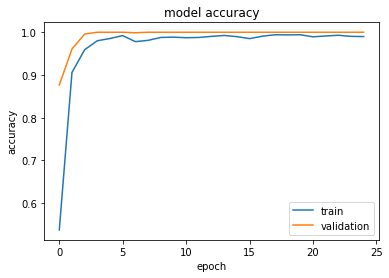

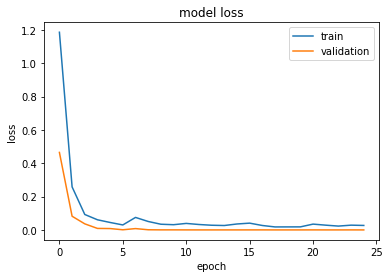

In [18]:
# plot training history
#  "Accuracy"
plt.plot(version1.history['accuracy'])
plt.plot(version1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()
# "Loss"
plt.plot(version1.history['loss'])
plt.plot(version1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation']) #loc='lower right'
plt.show()

In [19]:
model.evaluate(X_train, y_train)

208/208 [==============================] - 2s 8ms/step - loss: 1.7507e-06 - accuracy: 1.0000


[1.7507190932519734e-06, 1.0]

In [20]:
acc = version1.history['accuracy']
np.amax(acc)

0.9941264986991882

In [23]:
print("[INFO] evaluating network...")
y_test_numeric = y_test.rename(columns={"downwards": 0, "front": 1, "side": 2, "upwards": 3})
predictions = model.predict(x=X_test, batch_size=128)
print(classification_report(y_test_numeric.idxmax(axis="columns").values,
                            predictions.argmax(axis=1), target_names=['downwards', 'front', 'side', 'upwards']))

[INFO] evaluating network...
              precision    recall  f1-score   support

   downwards       1.00      1.00      1.00       221
       front       1.00      1.00      1.00       467
        side       1.00      1.00      1.00       892
     upwards       1.00      1.00      1.00        80

    accuracy                           1.00      1660
   macro avg       1.00      1.00      1.00      1660
weighted avg       1.00      1.00      1.00      1660



# Evaluating our Video Classification Model

## Defining Model architecture and loading weights

In [1]:
# imports
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.applications.vgg16 import VGG16
import cv2
import math
import os
from glob import glob
from scipy import stats as s

In [2]:
# base pretrained model
base_model = VGG16(weights='imagenet', include_top=False)

In [3]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(153600,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [4]:
# loading the trained weights
model.load_weights("weight_v1.hdf5")

# compiling the model
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

## Generating predictions for all test videos

In [28]:
# reading in test labels for verification later
train = pd.read_csv('material/test_labels.csv', sep=';')

# creating the dummy tags
trainLabel = pd.read_csv('material/train_frames.csv')
y = trainLabel['class']
y = pd.get_dummies(y)

In [29]:
# creating two lists to store predicted and actual tags
predict = []
actual = []

# for loop to extract frames from each test video
for i in tqdm(range(train['NameOfFile'].shape[0])):
    count = 0
    videoFile = train['NameOfFile'][i]
    cap = cv2.VideoCapture('material/raw_test_videos/'+videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    
    # removing all other files from the temp folder
    files = glob('temp/*')
    for f in files:
        os.remove(f)
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        #if (frameId % math.floor(frameRate) == 0):
            # storing the frames of this particular video in temp folder
        else:
            filename ='temp/' + "_frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()
    
    # reading all the frames from temp folder
    images = glob("temp/*.jpg")
    
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(480, 640, 3))
        img = image.img_to_array(img)
        img = img/480
        prediction_images.append(img)
    
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    
    # extracting features using pre-trained model
    prediction_images = base_model.predict(prediction_images)
    
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 15*20*512)
    
    # predicting tags for each array
    # predicting tags for each array
    prediction = (model.predict(prediction_images) > 0.5).astype("int32")
    predictFrame = []
    for pre in prediction:
        if pre[0] == 1:
            predictFrame.append('downwards')
        elif pre[1] == 1:
            predictFrame.append('front')
        elif pre[2] == 1:
            predictFrame.append('side')
        else:
            predictFrame.append('upwards')

    # appending the mode of predictions in predict list to assign the tag to the video
    predict.append(s.mode(predictFrame)[0][0])
    
    # appending the actual tag of the video
    actual.append(train['label'].loc[train['NameOfFile'] == videoFile].values[0])

100%|██████████| 24/24 [01:23<00:00,  3.47s/it]


In [30]:
# checking the accuracy of the predicted tags
from sklearn.metrics import accuracy_score
accuracy_score(predict, actual)*100

100.0

In [14]:
# predict

In [15]:
# actual

# Evaluate Model by looking at Frame prediction

In [5]:
# reading in test labels for verification later
train = pd.read_csv('material/test_labels.csv', sep=';')

# creating the dummy tags
trainLabel = pd.read_csv('material/train_frames.csv')
y = trainLabel['class']
y = pd.get_dummies(y)

In [6]:
# create all frames and csv with labels and frame name

# clear temp folder
files = glob('temp/*')
for f in files:
    os.remove(f)

frameFileNames = []
frameFileLabels = []

# for loop to extract frames from each test video
for i in tqdm(range(train['NameOfFile'].shape[0])):
    count = 0
    videoFile = train['NameOfFile'][i]
    cap = cv2.VideoCapture('material/raw_test_videos/'+videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    x=1

    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        else:
            filename ='temp/' + videoFile + "_frame%d.jpg" % count;count+=1
            frameFileNames.append(filename)
            frameFileLabels.append(train['label'][i])
            cv2.imwrite(filename, frame)
    cap.release()


# storing the images and their labels in a dataframe
test_frames = pd.DataFrame()
test_frames['image'] = frameFileNames
test_frames['label'] = frameFileLabels

# converting the dataframe into csv file 
test_frames.to_csv('temp/test_frames.csv',header=True, index=False)

100%|██████████| 24/24 [00:11<00:00,  2.03it/s]


In [7]:
# make predicitons on all frames


# creating two lists to store predicted and actual tags
predictFrame = []
actualFrame = []

# reading all the frames from temp folder
images = glob("temp/*.jpg")

# reading actual labels from temp folder
train = pd.read_csv('temp/test_frames.csv')

# open all frames and convert to np array
prediction_images = []
for i in range(len(images)):
    img = image.load_img(images[i], target_size=(480, 640, 3))
    img = image.img_to_array(img)
    img = img/480
    prediction_images.append(img)
    actualFrame.append(train['label'].loc[train['image'] == images[i]].values[0])

# converting all the frames for a test video into numpy array
prediction_images = np.array(prediction_images)

# extracting features using pre-trained model
prediction_images = base_model.predict(prediction_images)

# converting features in one dimensional array
prediction_images = prediction_images.reshape(prediction_images.shape[0], 15*20*512)

# predicting tags for each array
prediction = (model.predict(prediction_images) > 0.5).astype("int32")
for pre in prediction:
    if pre[0] == 1:
        predictFrame.append('downwards')
    elif pre[1] == 1:
        predictFrame.append('front')
    elif pre[2] == 1:
        predictFrame.append('side')
    else:
        predictFrame.append('upwards')

In [8]:
# checking predicted and actual frames labels which dont match
count_corrcet = 0
count_false = 0
for i in range(0, len(predictFrame)):
    if predictFrame[i] == actualFrame[i]:
        count_corrcet +=1
    else:
        print('frame ' + str(i),predictFrame[i], actualFrame[i])
        print(frameName[i])
        count_false +=1

test_acc = (count_corrcet / (count_corrcet + count_false)) *100
print('Test Accuracy {:.2f}%'.format(test_acc))

Test Accuracy 100.00%


# Evaluate single Video

In [35]:
# clear temp folder
files = glob('temp/*')
for f in files:
    os.remove(f)

# extract frames from the video and store them
count = 0
# videoFile = '_tigfCJFLZg_00214.mp4' # should be "downwards" but is "front"
# videoFile = '_8Vy3dlHg2w_00001.mp4' # should be "upwards" is "upwards"
# videoFile = '3PLiUG_DuC8_00346.mp4' # should be "upwards" but is "downwards"
videoFile = '_tigfCJFLZg_00181.mp4' # should be "side" is "side"
#videoFile = 'Video_62.mp4' # should be "front" but includes camera switch
cap = cv2.VideoCapture('material/single_videos/'+videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate

while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    else:
        filename ='temp/' + videoFile + "_frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

# creating two lists to store predicted and actual tags
predictFrame = []

# reading all the frames from temp folder
images = glob("temp/*.jpg")

# open all frames and convert to np array
prediction_images = []
for i in range(len(images)):
    img = image.load_img(images[i], target_size=(480, 640, 3))
    img = image.img_to_array(img)
    img = img/480
    prediction_images.append(img)

# converting all the frames for a test video into numpy array
prediction_images = np.array(prediction_images)

# extracting features using pre-trained model
prediction_images = base_model.predict(prediction_images)

# converting features in one dimensional array
prediction_images = prediction_images.reshape(prediction_images.shape[0], 15*20*512)

# predicting tags for each array
prediction = (model.predict(prediction_images) > 0.5).astype("int32")
for pre in prediction:
    if pre[0] == 1:
        predictFrame.append('downwards')
    elif pre[1] == 1:
        predictFrame.append('front')
    elif pre[2] == 1:
        predictFrame.append('side')
    else:
        predictFrame.append('upwards')

In [36]:
predictFrame

['side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'front',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'front',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'front',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'front',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'side',
 'front',
 'side',
 'side',
 'side',
 'side',
 'sid

In [37]:
#most labels say:
s.mode(predictFrame)[0][0]

'side'

In [38]:
# checking predicted and actual frames labels which dont match
counterA = 0
counterB = 0
for i in range(0, len(predictFrame)):
    if predictFrame[i] == 'downwards':
        counterA +=1
    else:
        counterB +=1 
print('correct: ', counterA, 'false: ',counterB)

correct:  0 false:  133
